# Puntos de interés turístico

Cargamos las librerías necesarias:

In [1]:
import random

import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler

import smopy

En este documento se busca automatizar la localización de sitios turísticos a través de los metadatos de las fotografías de flickr. Partiremos de un dataset ya preparado con fotografías realizadas en Barcelona.

In [2]:
geo_df = pd.read_csv('barcelona.csv', header=0)
geo_df.sample(5)

latitude  longitude
2755   41.395333   2.162000
18566  41.409840   2.137012
13119  41.370798   2.149882
18250  41.391570   2.164925
6532   41.384190   2.183811

<div class="alert alert-block alert-info">
Visualizamos las localizaciones de las fotografías mediante un scatter plot.
</div>

Comenzaremos haciendo un scatter plot con los parámetros por defecto:

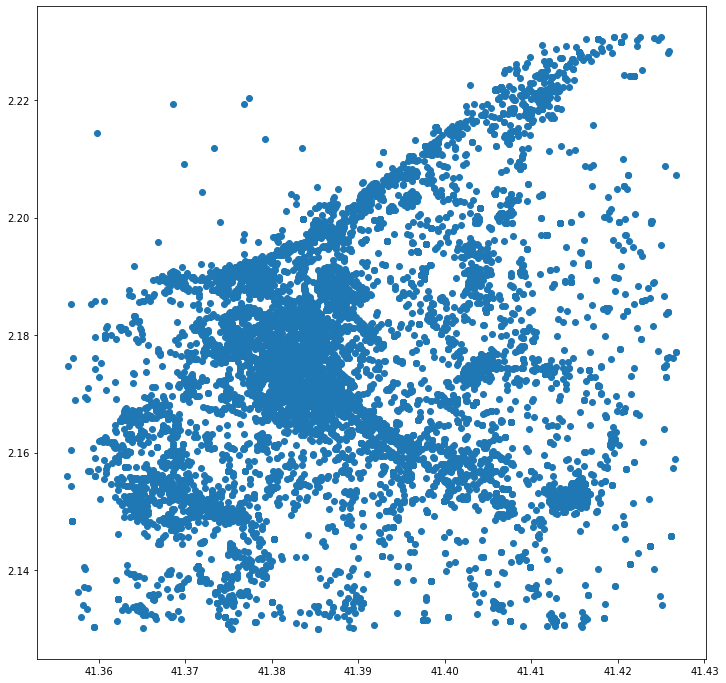

In [3]:
plt.figure(figsize=(12, 12))
plt.scatter(geo_df['latitude'], geo_df['longitude'])

Parece haber una zona con mayor densidad en el centro, una línea arriba y algunos otros puntos más, pero no se ven claramente las diferencias.

Después de probar varios valores para los parámetros *s* y *alpha* hemos obtenido este gráfico:

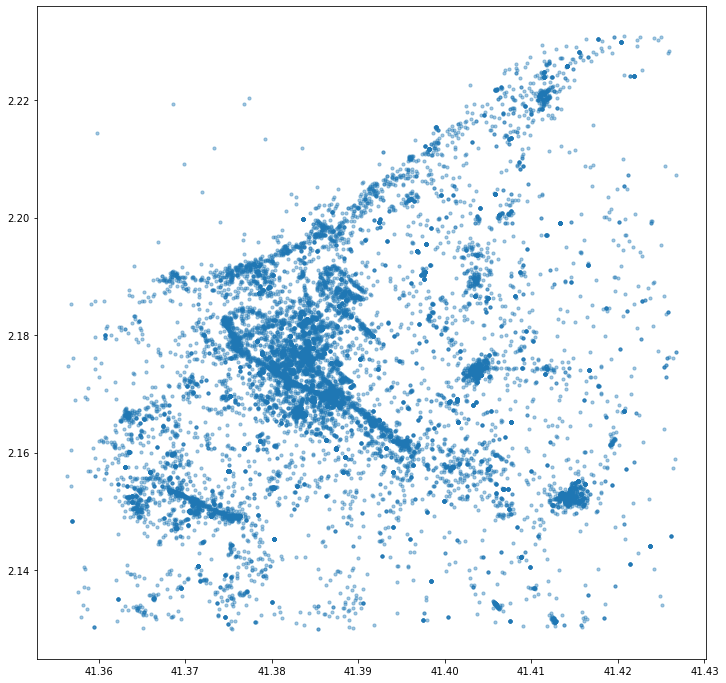

In [4]:
plt.figure(figsize=(12, 12))
plt.scatter(geo_df['latitude'], geo_df['longitude'], s=10, alpha=0.4)

Podemos distinguir algo mejor los puntos más densos que podrían agruparse.

Hemos intentado ver el gráfico invirtiendo los ejes y hemos obtenido este gráfico:

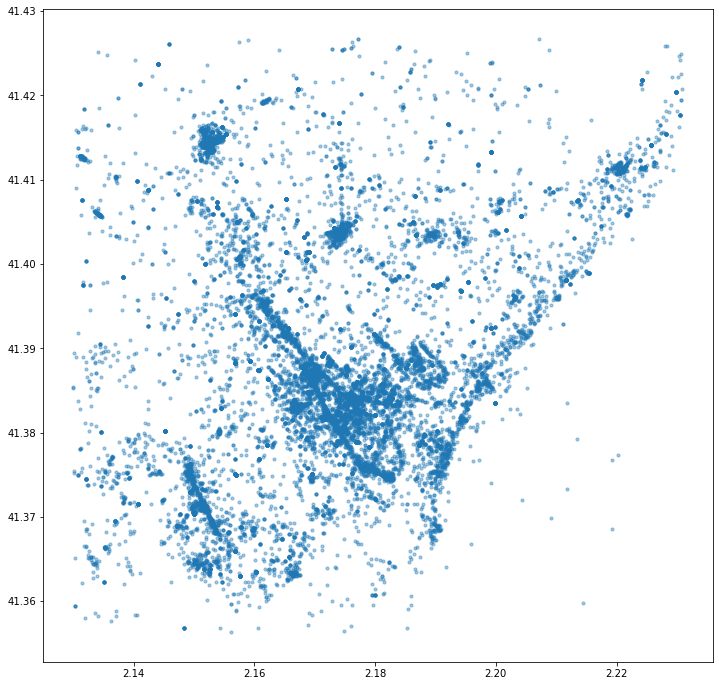

In [5]:
plt.figure(figsize=(12, 12))
plt.scatter(geo_df['longitude'], geo_df['latitude'], s=10, alpha=0.4)

Esta imagen nos recuerda algo al perfil de la misma Barcelona. Podemos distinguir una zona más densa en lo que sería la costa y otra en lo que podría ser el centro de la ciudad. También hay algunos puntos en lo que sería el mar, que podrían ser de fotos realizadas en cruceros llegando o saliendo de Barcelona.

Esta suposición no está basada en otra cosa que una impresión a partir de la imagen visualizada. Más adelante veremos si es cierta o no.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

En la visualización podemos ver que se destacan algunas zonas con mayor densidad que otras. Cada zona parece seguir una distribución. Después de trabajar en el documento *Métodos de clustering.ipynb* con los datasets *blobs*, *moons* y *circles* creamos que el mejor método que podemos aplicar a este caso es DBSCAN.

DBSCAN es un método que se basa en la densidad para obtener los clusters. A diferencia de k-means, no agrupa los datos en torno a unos puntos centrales, sino que se van agrupando mediante la unión de puntos cercanos. Para decidir esta unión será clave determinar el valor del parámetro *eps*. También será importante decidir un mínimo de elementos porque consideramos que se puede formar un grupo (parámetro *min_samples*).

K-means es mejor cuando tenemos datos que tienden a formar grupos esféricos, para estos datos no daría un buen resultado. Además, DBSCAN nos ayuda también a encontrar valores *outliers*. Útil en este caso, ya que, como hemos dicho anteriormente, parece que hay puntos que se podrían considerar *outliers*.

<div class="alert alert-block alert-info">
Para realizar prototipos de modelado primero se recomienda elegir un subconjunto de los datos que sea representativo. Seleccionaremos una muestra del DataFrame original y visualizaremos como en el punto anterior, para comprobar su similitud.
</div>

Para mejorar el coste computacional al realizar el *clustering*, haremos una reducción de casos mediante un muestreo aleatorio con la función *sample()*.

Veamos el tamaño total de los datos:

In [6]:
geo_df.shape

(19316, 2)

Tenemos un total de 19.316 datos de fotografías. Intentaremos tomar un subconjunto de 1000 instancias y veremos si se mantienen las mismas densidades que hemos visto en el gráfico anterior:

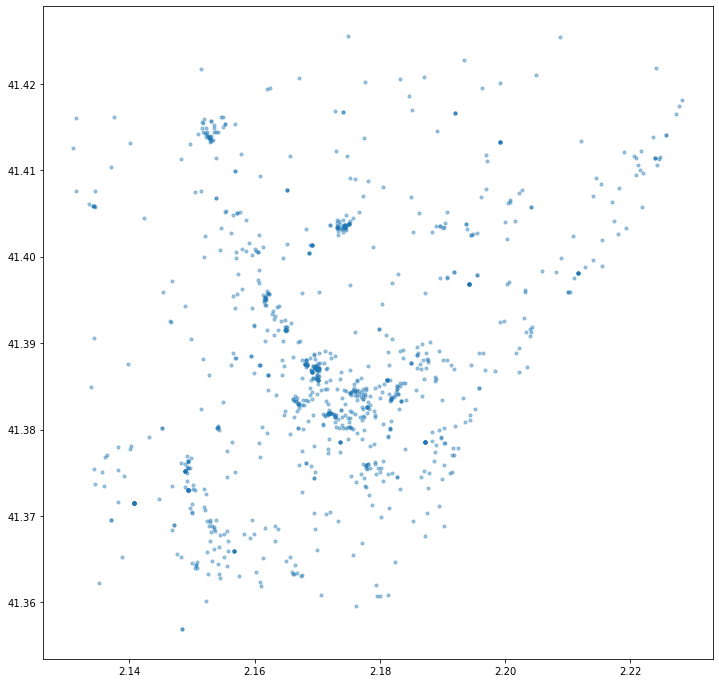

In [7]:
sub_df = geo_df.sample(1000, random_state=123)
plt.figure(figsize=(12, 12))
plt.scatter(sub_df['longitude'], sub_df['latitude'], s=10, alpha=0.4)

Pueden intuir algunas de las zonas más densas, pero perdemos mucha información. Tenemos demasiados pocos datos.

Probamos con algo más de datos, 5000, casi el 25% del conjunto original:

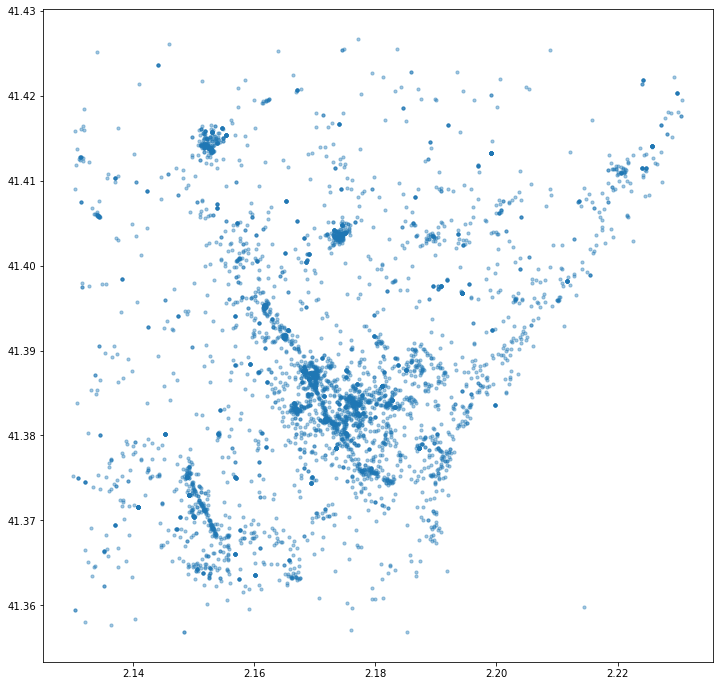

In [8]:
sub_df = geo_df.sample(5000, random_state=123)
plt.figure(figsize=(12, 12))
plt.scatter(sub_df['longitude'], sub_df['latitude'], s=10, alpha=0.4)

Aquí podemos ver mejor las zonas más densas que habíamos visto con el conjunto original.

Elegiremos este subconjunto para realizar el *clustering*.

<div class="alert alert-block alert-info">
Ahora ajustamos el algoritmo de clustering para encontrar los diferentes grupos sobre el conjunto reducido, y visualizamos el resultado coloreando cada punto sobre la base del grupo al que pertenece.
</div>

Antes de realizar la clusterización con DBSCAN, normalizaremos los parámetros, puesto que si vemos los intervalos de latitud y longitud podemos ver que son bastantes distintos.

In [9]:
print('Latitud: ',min(sub_df['latitude']), max(sub_df['latitude']))
print('Longitud: ',min(sub_df['longitude']), max(sub_df['longitude']))

Latitud:  41.356831 41.426679
Longitud:  2.130146 2.230659


Como hemos visto en los[ejemplos en scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py), es mejor normalizar los valores, puesto que el parámetro latitud podría influenciar de forma significativa en el resultado.

Utilizaremos la librería *StandardScaler*.

In [10]:
sub_df_norm = StandardScaler().fit_transform(sub_df)

# Guardamos los valores en formato dataframe
sub_df_norm = pd.DataFrame(sub_df_norm) 
sub_df_norm = sub_df_norm.rename(columns = {0: 'latitude', 1: 'longitude'})

# Comprobamos
sub_df_norm

latitude  longitude
0    -0.490378  -0.132691
1     0.016530  -0.080536
2    -0.104684  -0.111310
3     0.013137   0.021453
4    -1.105494  -1.235792
...        ...        ...
4995 -0.254876  -0.073409
4996 -0.183774   0.289356
4997 -0.083056  -0.488329
4998 -0.952404  -1.256566
4999  1.424378  -1.620491

[5000 rows x 2 columns]

Para ayudarnos en la elección del parámetro *eps* hemos utilizado el procedimiento descrito en el blog [towards data sciencie](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc). Con la ayuda de la librería *NearestNeighbors* calcularemos las distancias entre los distintos datos y después los visualizaremos en un gráfico.

Un valor óptimo de *eps* será aquel valor cercano al punto máximo de la curvatura. Este procedimiento sería la aplicación del método del codo en DBSCAN.

In [11]:
# Calculamos las distancias
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(sub_df_norm)
distances, indices = nbrs.kneighbors(sub_df_norm)

# Comprobamos
distances

array([[0.        , 0.02832444],
       [0.        , 0.04125155],
       [0.        , 0.        ],
       ...,
       [0.        , 0.00162018],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [12]:
# Ordenamos las distancias
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Visualizamos el grafo
plt.plot(distances)

Viendo la curva, parece que un punto óptimo de *eps* estaría entre 0.1 y 0.2.

Implementamos el modelo:

(Hemos ido probando distintos valores hasta que con *eps* = 0.15 y *min_samples* = 25 hemos obtenido un resultado donde creamos que los datos se parten en grupos bastante buenos)

In [13]:
model = cluster.DBSCAN(eps = 0.15, min_samples=25).fit(sub_df_norm)

Veamos el total de clusters que ha creado:

In [14]:
print(np.unique(model.labels_))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Tenemos un total de 17 clusters.

Imprimimos ahora el mismo gráfico que al inicio pero destacando los grupos con el mapa de colores *tab20*.

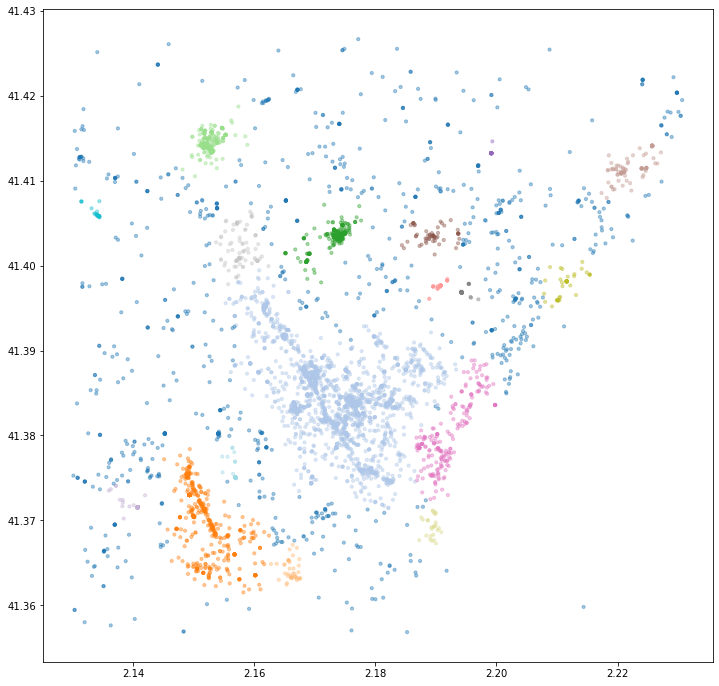

In [15]:
plt.figure(figsize=(12, 12))
plt.scatter(sub_df['longitude'], sub_df['latitude'], s=10, alpha=0.4, cmap='tab20', c=model.labels_)

<div class="alert alert-block alert-info">
Eliminamos ahora los puntos que consideramos outliers y visualizamos:
</div>

En los distintos grupos que tenemos hemos visto que existe una etiqueta -1, esta etiqueta hace referencia a los puntos que se han identificado como valores *outliers*. Ésta es una característica de DBSCAN que nos ayuda a poder eliminarlos fácilmente.

Visualizamos los datos sin estos valores *outliers*:

In [16]:
# Nos quedamos solos los puntos originales, sin escalar, que pertenecen a algún cluster
clusters_df = sub_df[model.labels_ != -1]

# Comprobamos que entre clusters y outliers tenemos todos los datos del subconjunto
print(clusters_df.shape)
print(sub_df[model.labels_ == -1].shape)

# Eliminamos el -1 de las etiquetas para pintar los colores en el gráfico correctamente
colors = model.labels_[model.labels_ != -1]

# Comprobamos
print(np.unique(colors))
clusters_df.head()

(4124, 2)
(876, 2)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


latitude  longitude
5277   41.381687   2.169284
12841  41.388859   2.170228
1421   41.387144   2.169671
1217   41.388811   2.172074
8386   41.372984   2.149318

Efectivamente, entre los clusters y los outliers tenemos los 5000 puntos del subconjunto escogido.

En las etiquetas no encontramos el valor -1 y en el dataset parece todo correcto.

Vemos cómo queda el gráfico sin *outliers*:

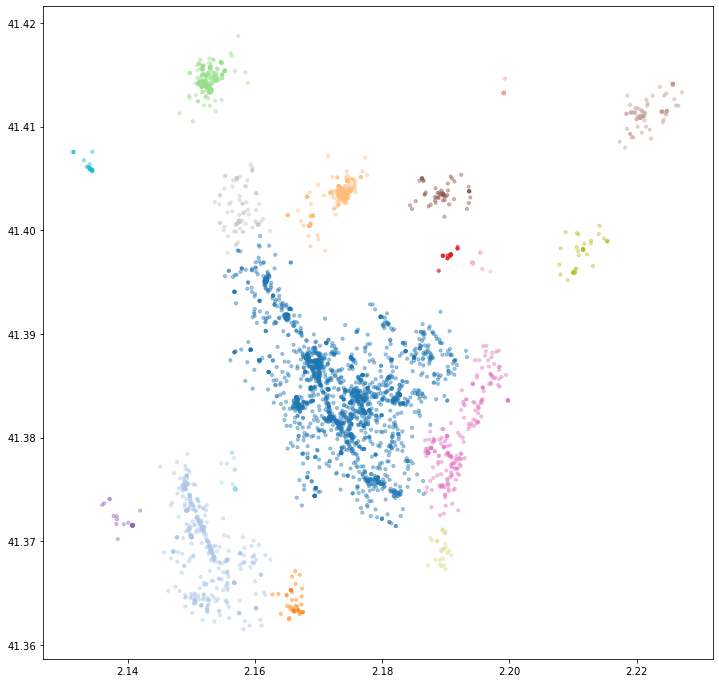

In [17]:
plt.figure(figsize=(12, 12))
plt.scatter(clusters_df['longitude'], clusters_df['latitude'], s=10, alpha=0.4, cmap='tab20', c=colors)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

Gracias a la facilidad de eliminar *outliers* de DBSCAN, podemos ver de forma nítida dónde están los clústeres en los que ha dividido los datos. Lo que era más difícil con tanto ruido.

Podemos distinguir 4 clusters a lo largo de lo que consideramos la costa. Otros tres clusters se encuentran más hacia el sur y vemos un gran cluster central que podría ser el área más metropolitana. Es lógico encontrar un clúster tan numeroso en esta área, puesto que es una zona mucho más turística y se realizarán más fotografías. Por último podemos ver otros grupos hacia el norte y el interior.

Para saber si estamos acertados en la suposición de que la forma en que veamos que están distribuidos los datos en el gráfico se corresponde al perfil de Barcelona, comprobaremos el punto medio de la latitud y longitud de cada clúster y veremos dónde se localizan:

In [18]:
# Utilizamos la variable color_clusters que hemos utilizado antes, ya que contiene sólo los clusters y no la etiqueta de los outliers
for i in list(np.unique(colors)):
    aux = sub_df[model.labels_ == i]
    mean_coords = [np.mean(aux['latitude']), np.mean(aux['longitude'])]
    print('Cluster',i, mean_coords)

Cluster 0 [41.38471883103602, 2.1733458443752776]
Cluster 1 [41.37015803353057, 2.151856372781065]
Cluster 2 [41.3641851707317, 2.1660713414634145]
Cluster 3 [41.403357452830186, 2.173320996855346]
Cluster 4 [41.414505024, 2.1529309399999996]
Cluster 5 [41.397589129032255, 2.1905527419354835]
Cluster 6 [41.41330225925926, 2.1991593703703707]
Cluster 7 [41.37173290476193, 2.140291777777778]
Cluster 8 [41.40357698245613, 2.1894032631578946]
Cluster 9 [41.41173220689654, 2.222487735632184]
Cluster 10 [41.379981372469636, 2.1913127165991906]
Cluster 11 [41.396887477272735, 2.194503886363636]
Cluster 12 [41.402166117647056, 2.157804094117647]
Cluster 13 [41.397852571428565, 2.2114414285714283]
Cluster 14 [41.36924046153846, 2.189363807692308]
Cluster 15 [41.40621271999999, 2.1338267600000003]
Cluster 16 [41.375826520000004, 2.1566132000000002]


A partir de estas coordenadas podemos buscarlas en un mapa como Google Maps y ver qué sitios son.

Tenemos un total de 17 clusters, por tanto, es un trabajo costoso, pero se puede realizar.

Hemos visto algunos puntos como el cluster 0 que está localizado cerca de Plaça Catalunya, el cluster 3 que está cerca de la Sagrada Família o el cluster 5 que está cerca de la sala Razzmatazz.

Podríamos seguir así y ver todos los clusters, pero si tuviéramos muchos más sería difícil ver manualmente estas localizaciones. Por eso no veremos en este punto a qué lugar pertenece cada coordenada como habíamos dicho. Lo dejamos por el siguiente punto donde buscaremos una forma de automatizar esta tarea.

<div class="alert alert-block alert-info">
Por último, representamos los puntos sin ruido sobre un mapa utilizando la librería <a href="https://pypi.org/project/smopy/">Smopy</a>. Para facilitar la interpretación, cada cluster será representado como el punto medio de todos los puntos que lo conforman.
</div>

Para realizar lo descrito anteriormente utilizaremos la librería *Smopy*. Esta librería nos permite ubicar puntos en mapas reales.

Debemos elegir el mapa que queremos mostrar y después pintar los puntos. Para elegir el mapa necesitaremos como parámetros: la latitud máxima y mínima y longitud máxima y mínima.

Observamos estos parámetros de nuestros datos.

Latitud:

In [19]:
[min(clusters_df['latitude']), max(clusters_df['latitude'])]

[41.36151, 41.418739]

Longitud:

In [20]:
[min(clusters_df['longitude']), max(clusters_df['longitude'])]

[2.131476, 2.227167]

Creamos ahora el mapa para que se adapte bien a esos límites que tenemos en nuestras coordenadas. También añadiremos un zoom de 11 que es el que mejor visualización nos ha proporcionado después de realizar varias pruebas.

Para pintar los puntos sobre el mapa haremos uso del bucle del apartado anterior pero cambiando la impresión de las coordenadas con texto por su inserción en el mapa.

In [21]:
# Elegir mapa
map = smopy.Map((41.36, 2.10, 41.42, 2.25), z=11)

# Calculamos las medias de latitud y longitud e imprimimos los puntos
ax = map.show_mpl(figsize=(12, 10))
for i in list(np.unique(colors)):
    aux = sub_df[model.labels_ == i]
    x = np.mean(aux['latitude'])
    y = np.mean(aux['longitude'])
    x, y = map.to_pixels(x, y)
    ax.plot(x, y, 'or', ms=5, mew=2);

Con esta visualización, podemos ver que nuestras suposiciones iniciales eran correctas. En el gráfico inicial, gracias a cómo se pintaban los puntos según su latitud y longitud, ya podíamos prever que formaban la silueta de Barcelona.

Veamos claramente 4 puntos más en la costa, un punto más separado en el centro de la ciudad y después algunos puntos al sur y norte de éste, tal y como habíamos visto en el gráfico en los clusters diferenciados por colores.

Si quisiéramos entrar más a detalle de cada punto, la librería *Smoopy* nos permitiría hacerlo ajustando los parámetros de latitud, longitud y zoom del mapa.

Para realizar el ejercicio hemos utilizado el mapa por defecto, ya que no necesitábamos más, pero *Smoopy* permite utilizar una gran variedad de mapas de Open Street que podemos encontrar en este [enlace](https://wiki.openstreetmap.org/wiki/Tile_servers)

### Conclusiones

En este documento hemos visto una situación real donde es útil aplicar técnicas de *clustering*.

Gracias a lo aprendido en el archivo *Métodos de clustering.ipynb* en el ejercicio 1 hemos podido elegir el método de clustering* que creamos que mejor se adapta a los datos que teníamos.

Después hemos consultado el blog de *towards data science* para ayudarnos a encontrar unos parámetros adecuados para DBSCAN. Una vez realizado el modelo, hemos podido ver cómo se agrupaban los datos. DBSCAN también nos permite eliminar muy fácilmente los *outliers* y ver los grupos creados de forma más limpia.

Finalmente hemos utilizado la librería *Smoopy* para localizar estos grupos en el mapa real de Barcelona y ver las zonas más populares donde se han realizado las fotos.